<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Keras
from keras import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, TimeDistributed, Dropout, Conv1D, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Common imports
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

#Parameters
window_hours = 168 #24*7
forecast_hours = 24
traing_hours = 24*365*2
test_hours = 24*365

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function for plot
def plot_learning_curves(loss, val_loss, x_min_max=None, y_min_max=None):
    if x_min_max is None and y_min_max is None:
        x_min_max = [1,100]
        y_min_max = [0,70]
        
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([x_min_max[0], x_min_max[1], y_min_max[0], y_min_max[1]])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
#Read csv file
df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)
df=df.dropna()

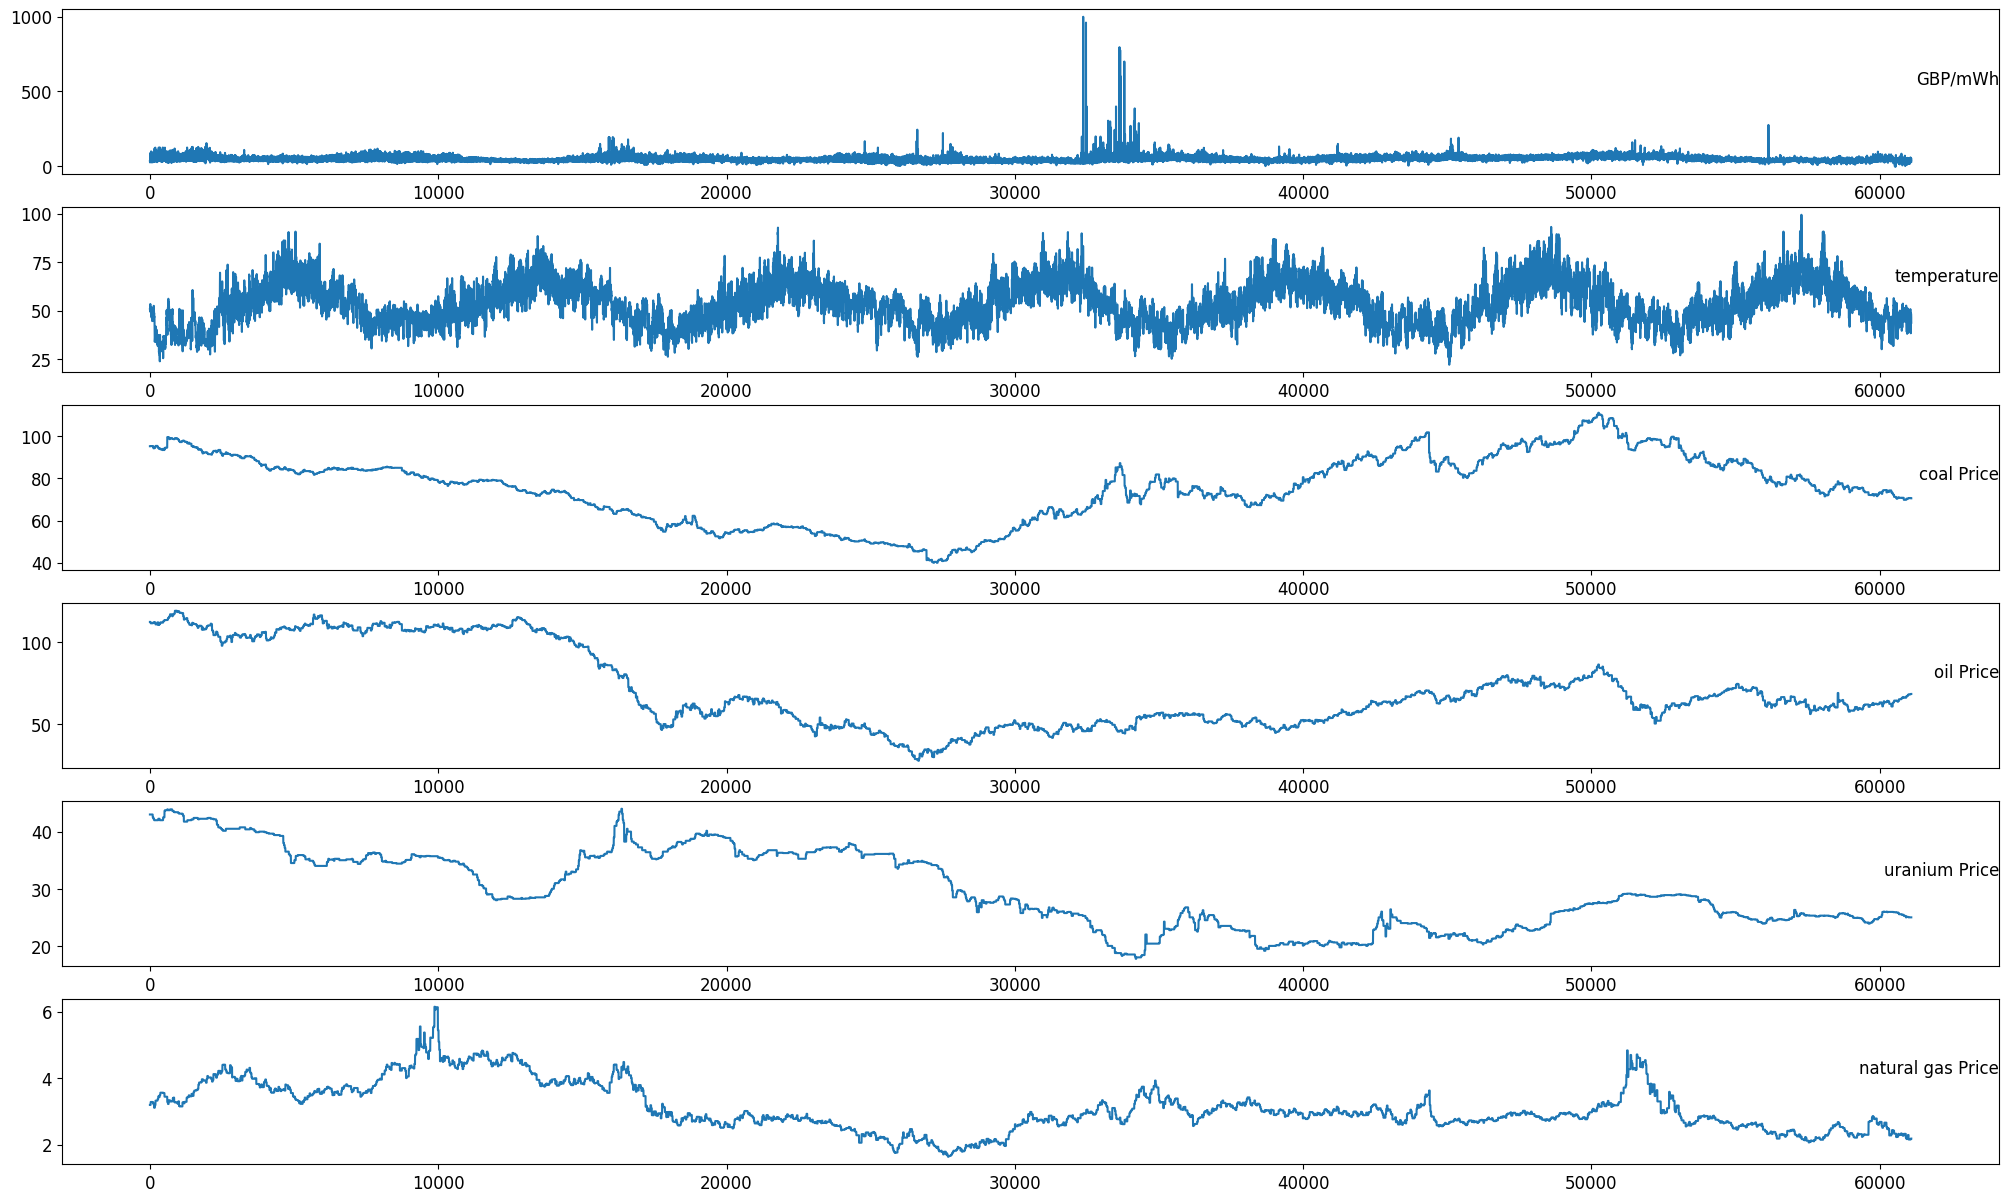

In [3]:
#Plot graph
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
# Normalize Datafram
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

aaa = df['GBP/mWh'].values.reshape(-1, 1)
print(aaa)

scaled_df1 = scaler1.fit_transform(aaa)
scaled_df1 = pd.DataFrame(scaled_df1)
print(scaled_df)
print(scaled_df1)

data = scaled_df.values

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

[[34.06]
 [30.54]
 [28.85]
 ...
 [37.71]
 [34.22]
 [32.75]]
              0         1         2         3         4         5
0      0.036832  0.370256  0.776920  0.925731  0.961905  0.345676
1      0.033319  0.366899  0.776920  0.925731  0.961905  0.345676
2      0.031632  0.365737  0.776920  0.925731  0.961905  0.345676
3      0.030454  0.366254  0.776920  0.925731  0.961905  0.345676
4      0.029306  0.365866  0.776920  0.925731  0.961905  0.345676
...         ...       ...       ...       ...       ...       ...
61092  0.048351  0.333979  0.429735  0.445616  0.276190  0.121286
61093  0.041833  0.324038  0.429735  0.445616  0.276190  0.121286
61094  0.040476  0.312548  0.429735  0.445616  0.276190  0.121286
61095  0.036992  0.293442  0.429735  0.445616  0.276190  0.121286
61096  0.035525  0.280274  0.429735  0.445616  0.276190  0.121286

[61097 rows x 6 columns]
              0
0      0.036832
1      0.033319
2      0.031632
3      0.030454
4      0.029306
...         ...
61092  0.0

168+24 인 192 시간으로 데이터를 편집한 것은 168시간으로 학습 시킨 뒤 24 시간을 예측하게 만들기 위함이라 예상됨

In [5]:
# 192hours time window (n_step+24)
series_reshaped =  np.array([data[i:i + (window_hours+forecast_hours)].copy() for i in range(len(data) - (window_hours+forecast_hours))])
print(series_reshaped.shape)

(60905, 192, 6)


In [6]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Train, valid, test data 만들기
X_train = series_reshaped[:traing_hours, :window_hours]
X_valid = series_reshaped[traing_hours:series_reshaped.shape[0]-test_hours, :window_hours]
X_test = series_reshaped[series_reshaped.shape[0]-test_hours:, :window_hours]
Y = np.empty((series_reshaped.shape[0], window_hours, forecast_hours))

for step_ahead in range(1, forecast_hours + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + window_hours, 0]
Y_train = Y[:traing_hours]
Y_valid = Y[traing_hours:series_reshaped.shape[0]-test_hours]
Y_test = Y[series_reshaped.shape[0]-test_hours:]
print(X_train.shape, X_valid.shape, X_test.shape, Y_train.shape, Y_valid.shape, Y_test.shape)

(17520, 168, 6) (34625, 168, 6) (8760, 168, 6) (17520, 168, 24) (34625, 168, 24) (8760, 168, 24)


#Note#
X_train.shape = (8760, 168,6) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 결과치를 (6) 6개의 요소에 대해 나타낸 것
Y_train.shape = (8760, 168,24) -> Ex) (8760) 중 어느 1시간에 대해 (168) 1주에 대한 미래 전력가격 결과를 (24) 24시간에 대해 나타낸 것

Deep Multivariate Recurrant Neural Network

In [7]:
#Training 

model6 = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    SimpleRNN(50, return_sequences=True),
    TimeDistributed(keras.layers.Dense(forecast_hours))
])

n_epochs = 15 #500
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model6.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])

Epoch 1/15
548/548 [==============================] - 29s 50ms/step - loss: 48.6974 - val_loss: 61.0858
Epoch 2/15
548/548 [==============================] - 28s 51ms/step - loss: 19.8644 - val_loss: 56.0883
Epoch 3/15
548/548 [==============================] - 29s 53ms/step - loss: 17.9360 - val_loss: 55.6094
Epoch 4/15
548/548 [==============================] - 29s 54ms/step - loss: 16.4786 - val_loss: 56.7350
Epoch 5/15
548/548 [==============================] - 30s 56ms/step - loss: 15.5343 - val_loss: 53.3283
Epoch 6/15
548/548 [==============================] - 29s 53ms/step - loss: 14.3225 - val_loss: 47.6136
Epoch 7/15
548/548 [==============================] - 30s 54ms/step - loss: 13.4833 - val_loss: 40.0561
Epoch 8/15
548/548 [==============================] - 29s 54ms/step - loss: 13.2137 - val_loss: 38.0443
Epoch 9/15
548/548 [==============================] - 30s 54ms/step - loss: 13.2278 - val_loss: 32.2674
Epoch 10/15
548/548 [==============================] - 28s 52ms/

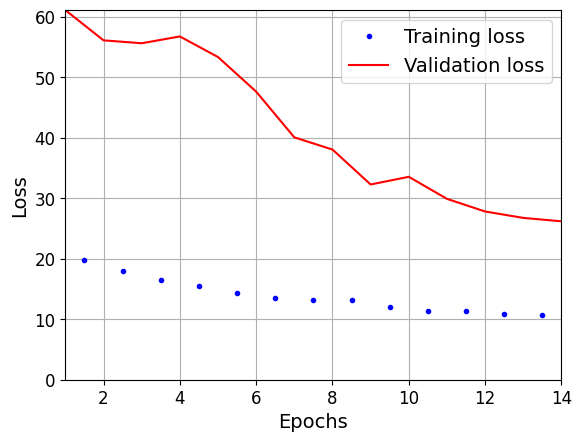

In [8]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 3s 11ms/step
            0      0
0   91.466759  65.84
1   86.252052  59.50
2   83.320847  56.00
3   82.578674  55.20
4   84.731155  57.95
..        ...    ...
95  84.793785  58.95
96  83.424019  57.45
97  81.508743  54.99
98  81.397949  54.92
99  83.558334  57.42

[100 rows x 2 columns]


<Axes: >

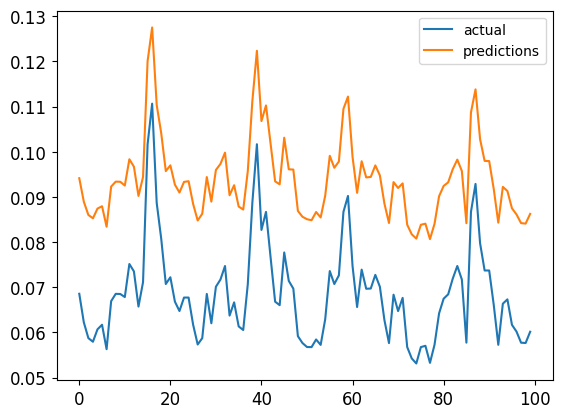

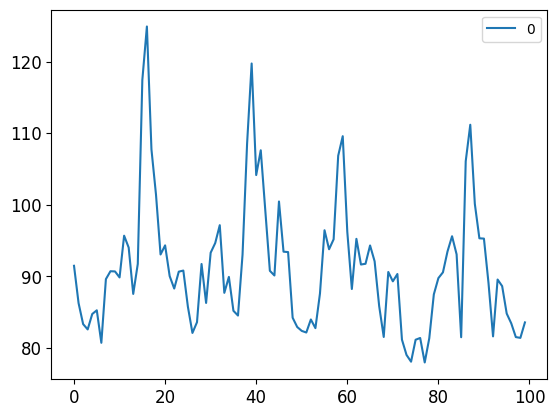

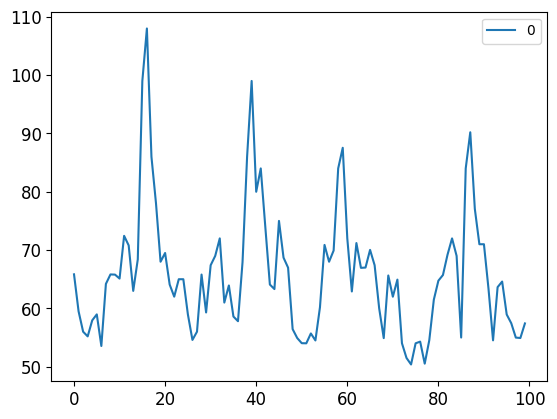

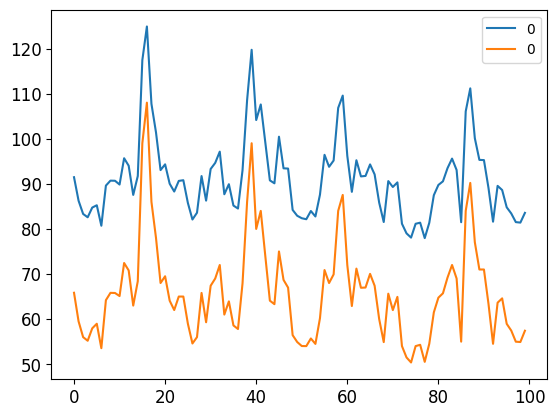

In [12]:
#Predict

Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual1 = actual
actual.to_csv('model_result/SimpleRNNresults.csv') 
actual['actual'][:100].plot(legend=True)
actual['predictions'][:100].plot(legend=True)

#actual2 = scaler.inverse_transform(last_list)
#actual3 = scaler.inverse_transform(actual['predictions'])
#print(actual['actual'])
#print(actual['predictions'])
#print(len(actual['predictions']))
#print(actual['predictions'][1])

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform1(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, forecast.size)
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

forecast = actual['predictions'].values.reshape(-1, 1)
forecast1 = actual['actual'].values.reshape(-1, 1)
#print(forecast)
#print(forecast1)
actual3 = scaler1.inverse_transform(forecast) # 예상값
actual4 = scaler1.inverse_transform(forecast1) # 실제값
#print(actual3)

actual3 = pd.DataFrame(actual3[:100])
actual4 = pd.DataFrame(actual4[:100])

actual5 = pd.concat([actual3, actual4], axis=1)

print(actual5)

#(actual3[:100],actual4[:100]).plot(legend=True)

actual3.plot(legend=True)
actual4.plot(legend=True)

actual5.plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Simple Long-Short Term Memory Model

In [13]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model8 = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 10
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks=[mc])
#history = model8.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks=[es,mc])


Epoch 1/10
548/548 [==============================] - 28s 48ms/step - loss: 28.1216 - val_loss: 37.4895
Epoch 2/10
548/548 [==============================] - 24s 45ms/step - loss: 16.6343 - val_loss: 26.1009
Epoch 3/10
548/548 [==============================] - 25s 45ms/step - loss: 14.9505 - val_loss: 27.3263
Epoch 4/10
548/548 [==============================] - 25s 46ms/step - loss: 13.8268 - val_loss: 25.8114
Epoch 5/10
548/548 [==============================] - 25s 46ms/step - loss: 13.2326 - val_loss: 22.7132
Epoch 6/10
548/548 [==============================] - 25s 46ms/step - loss: 12.3712 - val_loss: 21.1129
Epoch 7/10
548/548 [==============================] - 25s 46ms/step - loss: 11.7296 - val_loss: 19.8252
Epoch 8/10
548/548 [==============================] - 25s 45ms/step - loss: 11.4135 - val_loss: 20.1155
Epoch 9/10
548/548 [==============================] - 26s 47ms/step - loss: 11.2435 - val_loss: 20.1163
Epoch 10/10
548/548 [==============================] - 24s 44ms/

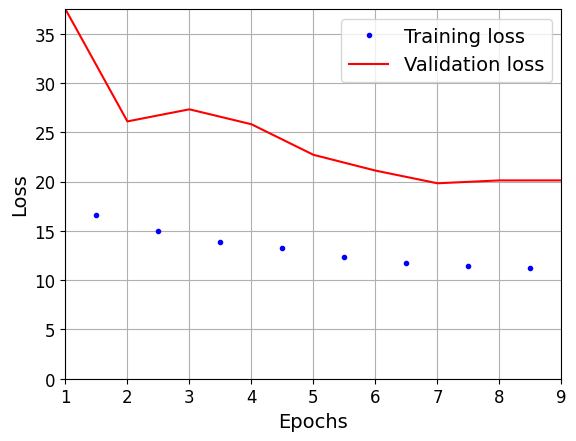

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 3s 9ms/step
            0      0
0   42.158691  65.84
1   40.356956  59.50
2   39.340488  56.00
3   39.082615  55.20
4   39.831528  57.95
..        ...    ...
95  40.164101  58.95
96  39.681313  57.45
97  39.036610  54.99
98  38.992527  54.92
99  39.744137  57.42

[100 rows x 2 columns]


<Axes: >

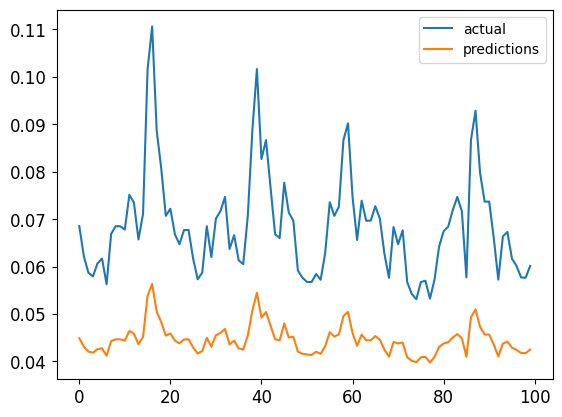

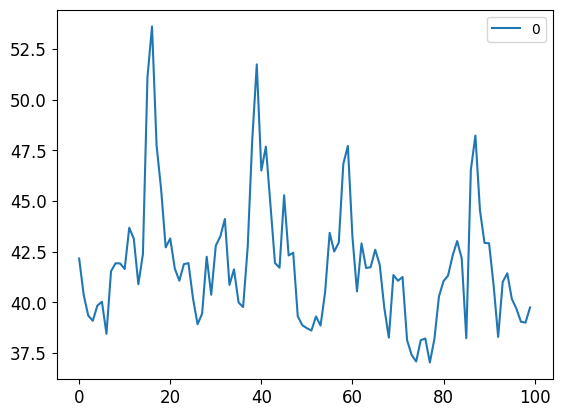

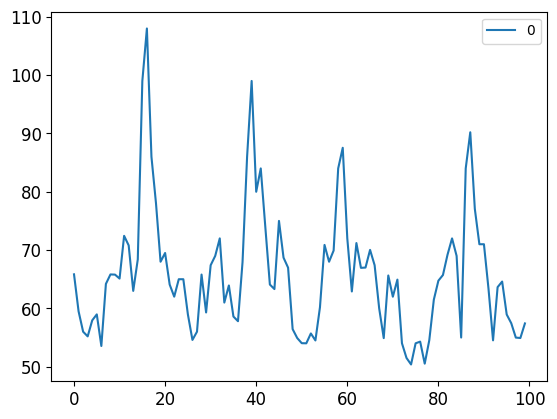

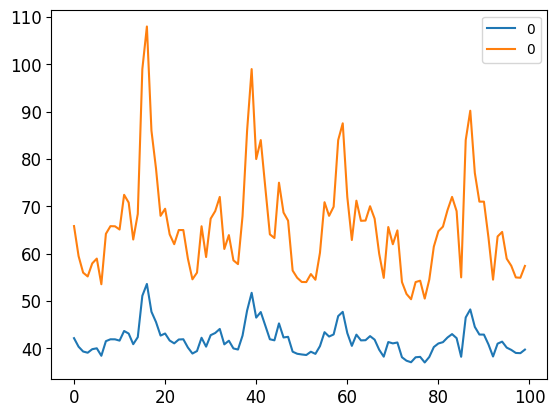

In [15]:
#Predict

Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual2 = actual
actual2.to_csv('model_result/LSTMresults.csv') 
actual2['actual'][:100].plot(legend=True)
actual2['predictions'][:100].plot(legend=True)

forecast = actual['predictions'].values.reshape(-1, 1)
forecast1 = actual['actual'].values.reshape(-1, 1)
#print(forecast)
#print(forecast1)
actual3 = scaler1.inverse_transform(forecast) # 예상값
actual4 = scaler1.inverse_transform(forecast1) # 실제값
#print(actual3)

actual3 = pd.DataFrame(actual3[:100])
actual4 = pd.DataFrame(actual4[:100])

actual5 = pd.concat([actual3, actual4], axis=1)

print(actual5)

#(actual3[:100],actual4[:100]).plot(legend=True)

actual3.plot(legend=True)
actual4.plot(legend=True)

actual5.plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Deep LSTM model

In [32]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model9 = Sequential([
    LSTM(80, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    Dropout(0,2),
    LSTM(40, return_sequences=True),
    Dropout(0,2),
    LSTM(30, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model9.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history = model9.fit(X_train, Y_train, epochs=n_epochs,
                    validation_data=(X_valid, Y_valid), callbacks = [mc])
#history = model9.fit(X_train, Y_train, epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 99s 176ms/step - loss: 18.0761 - val_loss: 18.3392
Epoch 2/500
548/548 [==============================] - 96s 175ms/step - loss: 13.4754 - val_loss: 16.6729
Epoch 3/500
548/548 [==============================] - 97s 176ms/step - loss: 12.2087 - val_loss: 17.7597
Epoch 4/500
548/548 [==============================] - 96s 176ms/step - loss: 11.4896 - val_loss: 17.8631
Epoch 5/500
548/548 [==============================] - 97s 176ms/step - loss: 10.8051 - val_loss: 16.4733
Epoch 6/500
548/548 [==============================] - 96s 175ms/step - loss: 10.4708 - val_loss: 16.6036
Epoch 7/500
548/548 [==============================] - 95s 174ms/step - loss: 10.2389 - val_loss: 15.2836
Epoch 8/500
548/548 [==============================] - 95s 173ms/step - loss: 10.0807 - val_loss: 15.3415
Epoch 9/500
548/548 [==============================] - 95s 173ms/step - loss: 9.9449 - val_loss: 16.0992
Epoch 10/500
548/548 [=========================

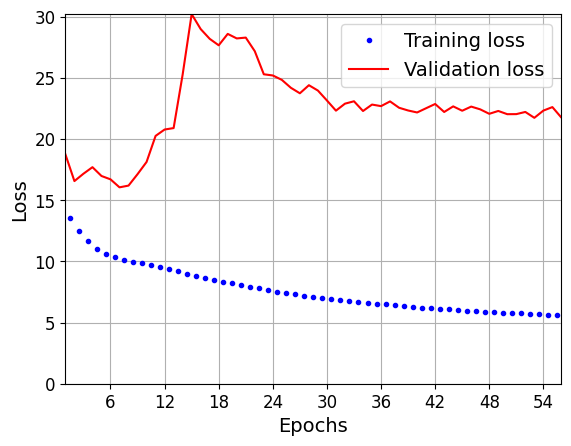

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

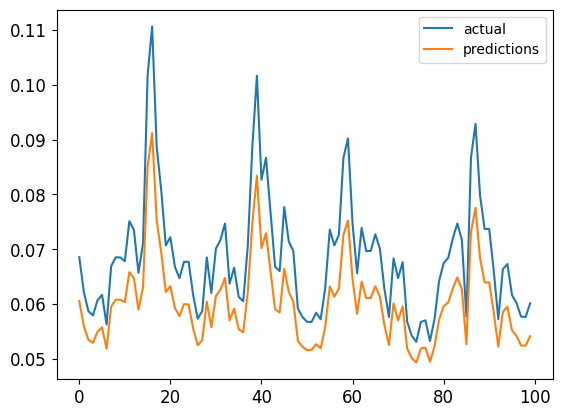

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual3 = actual
actual3.to_csv('model_result/DeepLSTMresults.csv') 
actual3['actual'][:100].plot(legend=True)
actual3['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)

Conv1D?

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

model10 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, X_train.shape[2]]),
    GRU(60, return_sequences=True),
    GRU(40, return_sequences=True),
    TimeDistributed(Dense(forecast_hours))
])

n_epochs = 500
model10.compile(loss="mape", optimizer="adam")
#es = EarlyStopping(monitor = 'val_loss',mode = 'min', verbose = 1, patience = 50)  # Early Stopping
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # Model Choice
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [mc])
#history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=n_epochs,
#                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es,mc])

Epoch 1/500
548/548 [==============================] - 30s 50ms/step - loss: 20.1465 - val_loss: 20.2326
Epoch 2/500
548/548 [==============================] - 27s 49ms/step - loss: 13.9747 - val_loss: 16.8128
Epoch 3/500
548/548 [==============================] - 27s 49ms/step - loss: 12.6040 - val_loss: 16.8075
Epoch 4/500
548/548 [==============================] - 27s 49ms/step - loss: 11.6067 - val_loss: 15.8368
Epoch 5/500
548/548 [==============================] - 27s 49ms/step - loss: 11.1065 - val_loss: 14.8159
Epoch 6/500
548/548 [==============================] - 27s 49ms/step - loss: 10.6634 - val_loss: 14.5553
Epoch 7/500
548/548 [==============================] - 27s 49ms/step - loss: 10.2541 - val_loss: 14.4075
Epoch 8/500
548/548 [==============================] - 27s 49ms/step - loss: 10.0435 - val_loss: 13.9985
Epoch 9/500
548/548 [==============================] - 27s 49ms/step - loss: 9.8779 - val_loss: 14.4603
Epoch 10/500
548/548 [==============================] - 

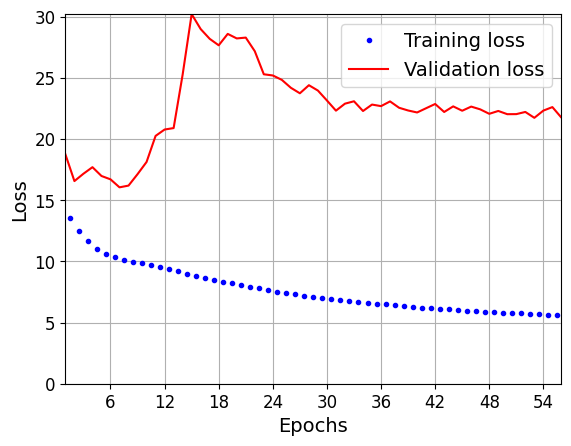

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],[1,max(history.epoch)],[0, max(max(history.history["loss"]),max(history.history["val_loss"]))])
plt.show()

274/274 [==============================] - 9s 32ms/step


<Axes: >

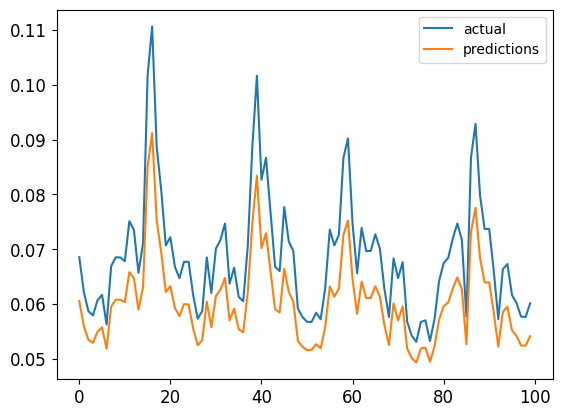

In [ ]:
#Predict

Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i,0,Y_pred.shape[2]-1]))  # 왜 마지막을 예측값으로 사용하는가..... .?!
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
actual4 = actual
actual4.to_csv('model_result/ConvIDresult.csv')
actual4['actual'][:100].plot(legend=True)
actual4['predictions'][:100].plot(legend=True)

Inverse transform 부분 만들기(순혁)
-(참고: https://coccocbox.tistory.com/5)